In [1]:
using DifferentialEquations, Plots #CSV, Tables, Dates, DataFrames, DiffEqSensitivity, JLD2,
cd(".")
### set up where CSV2Julia is
locationOfCSV2Julia="csv2model.py"
reactionsFile="reactions.csv"
parametersFile="parameters_k1_numbers.csv"
rateLawsFile="rateLaws.csv"
scan="scan"
#build a command to execute csv2julia
location=[locationOfCSV2Julia]
thisModelName="odeFileGenerated.jl"
arguments=[reactionsFile, parametersFile, rateLawsFile,thisModelName,scan]
cmd=`python3 $locationOfCSV2Julia $arguments`
run(cmd)
include("scanIncludes.jl");
include("variableNames.jl");
###

scan
Running CSV2JuliaDiffEq with parameters left as a function call to paramFun(n), for all params. We will also create a paramFun.jl file that should be included and defines all parameters. If this is incorrect, please re-run with 5th argument set to 'inline'
Opening rateLaws.csv as rate law file
Opening parameters_k1_numbers.csv as parameters file
Opening reactions.csv as reactions file
parameters can now be modified by name.
example to modify k_binding 1.5 fold higher:
modify["k_binding"]=1.5


In [2]:
#####
order=["B", "M", "BM", "C", "CB", "CM", "Cp", "CpB", "CpM", "CBM", "CpBM", "TAK1", "TAK1C", "TAK1p", "TAK1pC", "IKK", "IKKC", "IKKp", "IKKpC", "IKKppC", "IKKpp", "IKKi", "A20"]
function reorderModel(InputFileName,OutputFileName,symsNew)
    # this function takes an input model and and output file name and reorders the species into the order listed in symsNew
    # useful when comparing models that have ended up in a different order

    outputArray=["#file edited by reorderModel.jl to reorder the model species.\n"]
    #go through input file and save each line to an output array
    #only change the line that starts with the index we're looking for
    numberOfSpecies=length(symsNew)

    speciesEquationDict=Dict()
    nextLineSpecies=""
    functionDefinitionReached=false
    #lets go through the file line by line
    open(InputFileName) do f
        for i in enumerate(eachline(f))
            #this line's contents
            thisLine=i[2]

            if !functionDefinitionReached
                push!(outputArray,thisLine)
                functionDefinitionReached=startswith(strip(thisLine),"function")
                continue
            end
            #this will get the contents of the line if it's an equation or variable definition
            thisLineSplit=split(strip(thisLine),"=")
            #this will get the contents of the line if it's a code comment
            commentLine=split(strip(thisLine),"#")

            #lets check if this is a comment line where the only contents are one of the symbols
            if((length(commentLine)>1)&& (commentLine[2] in symsNew))
                #if we've found a species comment before an equation just make a note of the species so know what the next line represents
                nextLineSpecies=commentLine[2]
                continue
            end
            #if we set next line species on the previous iteration this line is an equation for that species, so save it to the dictionary
            if !isempty(nextLineSpecies)
                speciesEquationDict[nextLineSpecies]=thisLineSplit[2]
                nextLineSpecies=""
                continue
            end
        end

    end
    #loop through all the variable definitions and put them in the right order
    for thisSymEnum in enumerate(symsNew)
        thisSymIndex=thisSymEnum[1]
        thisSymName=thisSymEnum[2]
        #cMyct=maximum([y[1],0])
        thisLine="\t"*thisSymName*"=maximum([y["*string(thisSymIndex)*"],0])"
        push!(outputArray,thisLine)
    end

    #loop through all the equations and put them in the right order
    for thisSymEnum in enumerate(symsNew)
        thisSymIndex=thisSymEnum[1]
        thisSymName=thisSymEnum[2]
        #	#cMyct
        #   dy[1]= + 1.0
        commentLine="\t#"*thisSymName
        push!(outputArray,commentLine)
        thisLine="\tdy["*string(thisSymIndex)*"]="*speciesEquationDict[thisSymName]
        push!(outputArray,thisLine)
    end

    push!(outputArray,"end")

    #now write the output array to the output file
    open(OutputFileName,"w") do f
        for line in outputArray
            write(f, line*"\n")
        end

    end
    println("ODE file reordered, make sure to refer to the new species name array, that was used as input to this function, when fixing species, plotting etc")
end
reorderModel("C:\\Users\\bsms9jt3\\OneDrive - University of Brighton\\Documents\\Julia\\BCR_inoue_2016\\CSV2Julia_BCRwithA20\\odeFileGenerated.jl", "C:\\Users\\bsms9jt3\\OneDrive - University of Brighton\\Documents\\Julia\\BCR_inoue_2016\\CSV2Julia_BCRwithA20\\odeFileGenerated.jl", order)
include("C:\\Users\\bsms9jt3\\OneDrive - University of Brighton\\Documents\\Julia\\BCR_inoue_2016\\CSV2Julia_BCRwithA20\\odeFileGenerated.jl")
#####


ODE file reordered, make sure to refer to the new species name array, that was used as input to this function, when fixing species, plotting etc


odeFile (generic function with 1 method)

In [13]:
function plotsols(sollist,syms,labelnames) #list of sols, list of all species' names, list of labels of multiple conditions
#species'names must be in same order as written in model
    plot_array = Any[]
    for i in 1:length(syms)
        plotVar=plot()
        for j in 1:length(sollist)
            plot!(plotVar,sollist[j].t,sollist[j][i,:],label=labelnames[j])
        end
        push!(plot_array,plotVar) # make a plot and add it to the plot_array
    end
    titleArray=reshape(syms, 1, length(syms))
    return plot(plot_array...,layout=length(plot_array),title=titleArray,size=[1250,800])
end
#To change plot arguments, you can place a semi-colon to silence the output,
# then use plot! to print the new output

plotsols (generic function with 1 method)

In [3]:

function originalsignal(t)
    global PHASE
    global DOSE
    if PHASE == 1
        sinput=1.0;
        slate=0.05;
        sbase=0.0;
        tpulse=0.25;
        traise=0.5;
        tdecay=0.5;
        tdelay=0;
    else
        sinput = 1.0 - (1.0)*DOSE;
        #sbase = 0.01; #commented in original
        tpulse = 0.25;
        traise = 0.5;
        tdecay = 0.5;
        tdelay = 0;
        #slate = 0.05 - (0.05 - 0.01)*DOSE; #this line would make slate=0.01*DOSE. Commented in original
        sbase=0.0;
        slate=0.05 - (0.05)*DOSE;
    end

    signal=sbase;

    if t <= tdelay || PHASE==1
        signal = sbase;
    elseif tdelay < t && t <= (traise + tdelay)
        signal = (t - tdelay)*(sinput - sbase)/traise + sbase;
    elseif (traise + tdelay) < t && t <= (tpulse + traise + tdelay)
        signal = sinput;
    elseif (tpulse + traise + tdelay) < t
        signal = (sinput - slate)*exp(-(t - tpulse - traise - tdelay)/tdecay) + slate;
    end
    return signal
end
#function to quickly make mutants. Two phenotypes, fullmut (24params) or 8hyp
function card11mut(modify,mutantstrengthfactor,phenotype="fullmut")
    msf=mutantstrengthfactor
    if phenotype=="fullmut"
        mods=[msf,1/msf,msf,1/msf,msf,1/msf,msf,1/msf,msf,1/msf,msf,1/msf,msf,1/msf,msf,1/msf,msf,msf,msf,msf,1/msf,1/msf,1/msf,1/msf]
    elseif phenotype=="8hyp"
        mods=a=[1,1,1,1,1,1,1,1,1,1,msf,1,msf,1/msf,msf,1/msf,1,msf,1,msf,1,1,1,1/msf]#8hyp_mut
    end
    #Would lke to model mutations F123I and L225LI in the CARD11 domain.
    #Activating mutations!!
    #Cp dependent TAK1 phosphorylation, flux36
    modify["k1_CTpS"]=mods[1] #kCTpS
    modify["k2_kmCTpS"]=mods[2] #kmCTpS
    #CpB dependent TAK1 phosphorylation, flux37
    modify["k1_CBTpS"]=mods[3] #kCBTpS
    modify["k2_kmCBTpS"]=mods[4] #kmCBTpS
    #CpM dependent TAK1 phosphorylation, flux38
    modify["k1_CMTpS"]=mods[5] #kCMTpS
    modify["k2_kmCMTpS"]=mods[6] #kmCMTpS
    #CpBM dependent TAK1 phosphorylation, flux39
    modify["k1_CBMTpS"]=mods[7] #kCBMTpS
    modify["k2_kmCBMTpS"]=mods[8] #kmCBMTpS
    ##
    #Cp dependent TAK1C phosphorylation, flux43
    modify["k1_CTpCS"]=mods[9] #kCTpCS
    modify["k2_kmCTpCS"]=mods[10] #kmCTpCS
    #CpB dependent TAK1C phosphorylation, flux44
    modify["k1_CBTpCS"]=mods[11] #kCBTpCS
    modify["k2_kmCBTpCS"]=mods[12] #kmCBTpCS
    #CpM dependent TAK1C phosphorylation, flux45
    modify["k1_CMTpCS"]=mods[13] #kCMTpCS
    modify["k2_kmCMTpCS"]=mods[14] #kmCMTpCS
    #CpBM dependent TAK1C phosphorylation, flux46
    modify["k1_CBMTpCS"]=mods[15] #kCBMTpCS
    modify["k2_kmCBMTpCS"]=mods[16] #kmCBMTpCS
    ##
    #CARD11 activating mutations (F123I, L225LI) in the LATCH domain increase affinity for BCL10
    #Cp association to BCL10, flux17
    modify["k1_CpaB"]=mods[17] #kCpaB
    #C association to B, flux15
    modify["k1_CaB"]=mods[18] #kCaB
    #CM association to B, flux27
    modify["k1_CMaB"]=mods[19] #kCMaB
    #CpM association to B, flux29
    modify["k1_CpMaB"]=mods[20] #kCpMaB
    ##decreasing dissociation between Bcl10 and Card11mut (may not be needed)
    #CpB dissociation  flux18
    modify["k1_CpdB"]=mods[21] #kCpdB
    #CB dissociation flux16
    modify["k1_CdB"]=mods[22] #kCdB
    #CBM dissociation flux28
    modify["k1_CMdB"]=mods[23] #kCMdB
    #CpBM dissociation flux30
    modify["k1_CpMdB"]=mods[24] #kCpMdB
    return modify
end
function displaymodifiers(modify)
print(modify["k1_CTpS"]," ",modify["k2_kmCTpS"]," ",modify["k1_CBTpS"]," ",modify["k2_kmCBTpS"]," ",modify["k1_CMTpS"]," ",modify["k2_kmCMTpS"]," ",modify["k1_CBTpCS"]," ",modify["k2_kmCBTpCS"]," ",modify["k1_CTpCS"]," ",modify["k2_kmCTpCS"]," ",modify["k1_CBTpCS"]," ",modify["k2_kmCBTpCS"]," ",modify["k1_CMTpCS"]," ",modify["k2_kmCMTpCS"]," ",modify["k1_CBMTpCS"]," ",modify["k2_kmCBMTpCS"]," ",modify["k1_CpaB"]," ",modify["k1_CaB"]," ",modify["k1_CMaB"]," ",modify["k1_CpMaB"]," ",modify["k1_CpdB"]," ",modify["k1_CdB"]," ",modify["k1_CMdB"]," ",modify["k1_CpMdB"])
end

displaymodifiers (generic function with 1 method)

In [9]:

card11mut(modify,2)
displaymodifiers(modify)
tspan=[0.0,360.0]
sollist=[]
###
sollist=[]
for k_A20induction in [0.001,0.005,0.01,0.02]
	modify["k1_A20linearinduction"]=k_A20induction
#     uequilibrium_inoue=[0.698, 0.717, 0.093, 0.658, 0.152, 0.133, 9.237e-6, 1.849e-5, 1.367e-5, 0.057, 5.7677e-5, 0.731, 0.130, 0.113, 0.026, 0.719, 0.231, 0.009, 0.042, 2.625e-8, 2.000e-6, 4.076e-8,0,1]
    uequilibrium_inoue=ones(23)*0.3
	PHASE=1
    phase1_tspan=[0.0,1000.0]
	prob_phase1_inoue=ODEProblem(odeFile,uequilibrium_inoue,phase1_tspan,originalsignal,maxiters=1e6)
	phase1_sol=solve(prob_phase1_inoue)
	u0_endofphase1=float(phase1_sol[end])
	##define problem
	global PHASE=2
	global DOSE=0
	prob_inoue=ODEProblem(odeFile,u0_endofphase1,tspan,originalsignal) #nb pre stim graph included on exploration_BCR, better plot!
	sol=solve(prob_inoue)
	push!(sollist, sol)
end
###


2.0 0.5 2.0 0.5 2.0 0.5 2.0 0.5 2.0 0.5 2.0 0.5 2.0 0.5 2.0 0.5 2.0 2.0 2.0 2.0 0.5 0.5 0.5 0.5

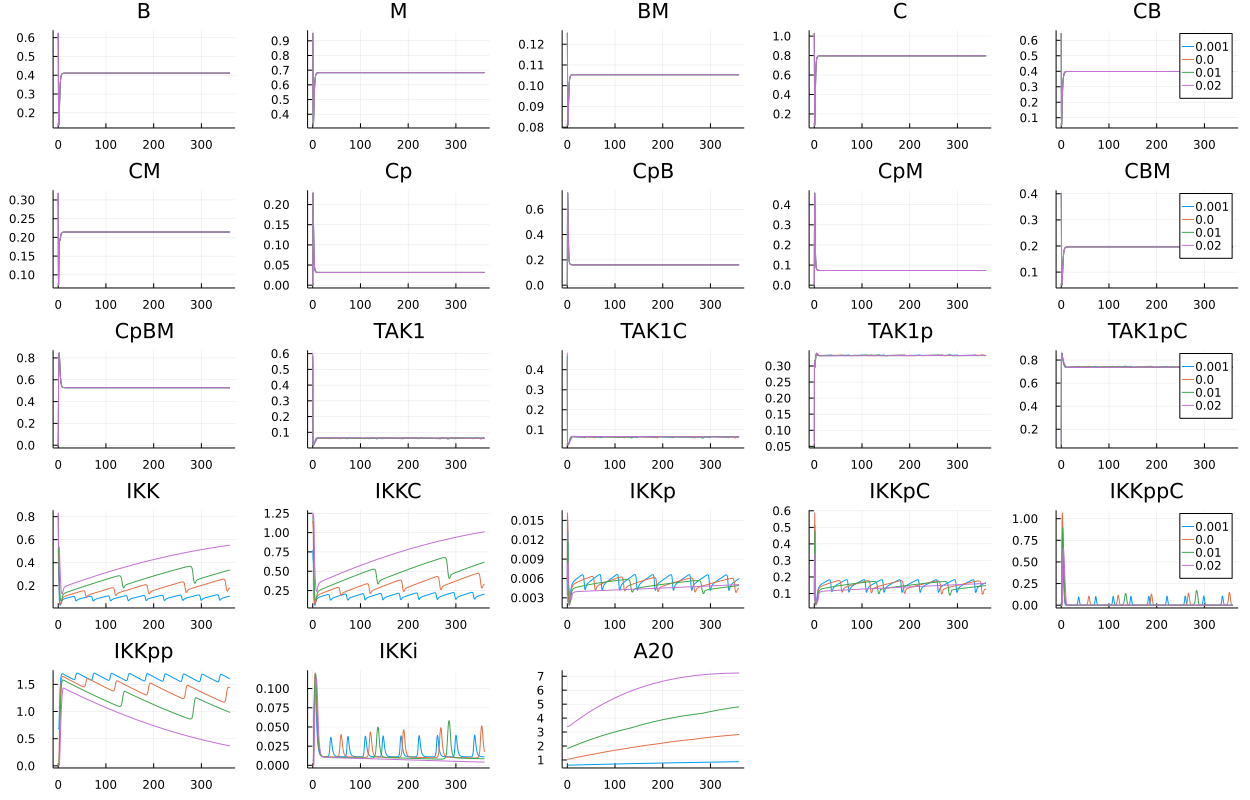

In [14]:
syms=order
plotsols(sollist,order,[0.001, 0.00, 0.01, 0.02])
plot!(figsize=[1250,800],legend=[:none :none :none :none :topright])

In [15]:
#####
#Here follows the MATLAB-version:
function inoue2016(delta_bcr,bcr,p,t)
    #signal section#
    global PHASE
    global DOSE
    if PHASE == 1
        sinput=1.0;
        slate=0.05;
        sbase=0.0;
        tpulse=0.25;
        traise=0.5;
        tdecay=0.5;
        tdelay=0;
    else
        sinput = 1.0 - (1.0)*DOSE;
        #sbase = 0.01; #commented in original
        tpulse = 0.25;
        traise = 0.5;
        tdecay = 0.5;
        tdelay = 0;
        #slate = 0.05 - (0.05 - 0.01)*DOSE; #this line would make slate=0.01*DOSE. Commented in original
        sbase=0.0;
        slate=0.05 - (0.05)*DOSE;
    end

    signal=sbase;

    if t <= tdelay || PHASE==1
        signal = sbase;
    elseif tdelay < t && t <= (traise + tdelay)
        signal = (t - tdelay)*(sinput - sbase)/traise + sbase;
    elseif (traise + tdelay) < t && t <= (tpulse + traise + tdelay)
        signal = sinput;
    elseif (tpulse + traise + tdelay) < t
        signal = (sinput - slate)*exp(-(t - tpulse - traise - tdelay)/tdecay) + slate;
    end
    ###############
    #parameters are in pfun and pmodfun is used for modifying them
    bcr_flux=zeros(82,1)

    #kCp0 * C	basal C phosphorylation	C => Cp
    bcr_flux[1] = pmodfun(1) * bcr[4];
    #kCpS * signal * C / (kmCpS + C)	signal-dependent C phosphorylation	signal -0 C => Cp
    bcr_flux[2] = (pmodfun(5) * signal * bcr[4])/(pmodfun(9) + bcr[4]);
    #kCpu * Cp / (kmCpu + Cp)	Cp dephosphorylation	Cp => C
    bcr_flux[3] = (pmodfun(13) * bcr[7]) / (pmodfun(17)+bcr[7]);
    #kCpB0 * CB	basal CB phosphorylation	CB => CpB
    bcr_flux[4] = pmodfun(2)* bcr[5];
    #kCpBS * signal * CB / (kmCpBS + CB)	signal-dependent CB phosphorylation	signal -0 CB => CpB
    bcr_flux[5] = (pmodfun(6) * signal * bcr[5]) / (pmodfun(10) + bcr[5]);
    #kCpBu * CpB / (kmCpBu + CpB)	CpB dephosphorylation	CpB => CB
    bcr_flux[6]= (pmodfun(14) * bcr[8]) / (pmodfun(19) + bcr[8]);
    #kCpM0 * CM	basal CM phosphorylation	CM => CpM
    bcr_flux[7] = pmodfun(3)* bcr[6];
    #CpMS * signal * CM / (kmCpMS + CM)	signal-dependent CM phosphorylation	signal -0 CM => CpM
    bcr_flux[8] = (pmodfun(7) * signal * bcr[6])/ (pmodfun(11)+bcr[6]);
    #CpMu * CpM / (kmCpMu + CpM)	CpM dephosphorylation	CpM => CM
    bcr_flux[9] = (pmodfun(15) * bcr[9])/(pmodfun(20)+bcr[9]);
    #kCpBM0 * CBM	basal CBM phosphorylation	CBM => CpBM
    bcr_flux[10] = pmodfun(4)*bcr[10];
    #kCpBMS * signal * CBM / (kmCpBMS + CBM)	signal-dependent CBM phosphorylation	signal -0 CBM => CpBM
    bcr_flux[11] = (pmodfun(8) * signal * bcr[10])/(pmodfun(12)+bcr[10]);
    #kCpBMu * CpBM / (kmCpBMu + CpBM)	CpBM dephosphorylation	CpBM => CBM
    bcr_flux[12] = (pmodfun(16) * bcr[11])/(pmodfun(21)+bcr[11]);
    #kBaM * B * M	association between B and M	B + M => BM
    bcr_flux[13] = pmodfun(22) * bcr[1] * bcr[2];
    #kBdM * BM	dissociation between B and M	BM => B + M
    bcr_flux[14] = pmodfun(33) * bcr[3];
    #kCaB * C * B	association between C and B	C + B => CB
    bcr_flux[15] = pmodfun(23) * bcr[4] * bcr[1];
    #kCdB * CB	dissociation between C and B	CB => C + B
    bcr_flux[16] = pmodfun(34) * bcr[5];
    #kCpaB * Cp * B	association between Cp and B	Cp + B => CpB
    bcr_flux[17] = pmodfun(29) * bcr[7] * bcr[1]; #have corrected from downloaded file, previously 28 was used here, and 29 was never used. -arran.
    #kCpdB * CpB	dissociation between Cp and B	CpB => Cp + B
    bcr_flux[18] = pmodfun(38) * bcr[8];
    #kCaM * C * M	association between C and M	C + M => CM
    bcr_flux[19] = pmodfun(24) * bcr[4] * bcr[2];
    #kCdM * CM	dissociation between C and M	CM => C + M
    bcr_flux[20] = pmodfun(35) * bcr[6];
    #kCpaM * Cp * M	association between Cp and M	Cp + M => CpM
    bcr_flux[21]  = pmodfun(30) * bcr[7] * bcr[2];
    #kCpdM * CpM	dissociation between Cp and M	CpM => Cp + M
    bcr_flux[22] = pmodfun(39) * bcr[9];
    #kCBaM * CB * M	association between CB and M	CB + M => CBM
    bcr_flux[23] = pmodfun(25) * bcr[5] * bcr[2];
    #kCBdM * CBM	dissociation between CB and M	CBM => CB + M
    bcr_flux[24] = pmodfun(36) * bcr[10];
    #kCpBaM * CpB * M	association between CpB and M	CpB + M => CpBM
    bcr_flux[25] = pmodfun(31) * bcr[8] * bcr[2];
    #kCpBdM * CpBM	dissociation between CpB and M	CpBM => CpB + M
    bcr_flux[26] = pmodfun(40) * bcr[11];
    #kCMaB * CM * B	association between CM and B	CM + B => CBM
    bcr_flux[27] = pmodfun(26) * bcr[6] * bcr[1];
    #kCMdB * CBM	dissociation between CM and B	CBM => CM + B
    bcr_flux[28] = pmodfun(37) * bcr[10];
    #kCpMaB * CpM * B	association between CpM and B	CpM + B => CpBM
    bcr_flux[29] = pmodfun(32) * bcr[9] * bcr[1];
    #kCpMdB * CpBM	dissociation between CpM and B	CpBM => CpM + B
    bcr_flux[30] = pmodfun(41) * bcr[11];
    #kCaBM * C * BM	association between C and BM	C + BM => CBM
    bcr_flux[31] = pmodfun(27) * bcr[4] * bcr[3];
    #kCdBM * CBM	dissociation between C and BM	CBM => C + BM
    bcr_flux[32] = pmodfun(42) * bcr[10];
    #kCpaBM * Cp * BM	association between Cp and BM	Cp + BM => CpBM
    bcr_flux[33] = pmodfun(28) * bcr[7] * bcr[3];
    #kCpdBM * CpBM	dissociation between Cp and BM	CpBM => Cp + BM
    bcr_flux[34] = pmodfun(43) * bcr[11];
    #kTp0 * TAK1	basal TAK1 phosphorylation	TAK1 => TAK1p
    bcr_flux[35] = pmodfun(44) * bcr[12];
    #kCTpS * Cp * TAK1 / (kmCTpS + TAK1)	Cp-dependent TAK1 phosphorylation	Cp -0 TAK1 => TAK1p
    bcr_flux[36] = (pmodfun(45) * bcr[7] * bcr[12])/(pmodfun(49) + bcr[12]);
    #kCBTpS * CpB * TAK1 / (kmCBTpS + TAK1)	CpB-dependent TAK1 phosphorylation	CpB -0 TAK1 => TAK1p
    bcr_flux[37] = (pmodfun(46) * bcr[11] * bcr[12])/(pmodfun(50) + bcr[12]);
    #kCMTpS * CpM * TAK1 / (kmCMTpS + TAK1)	CpM-dependent TAK1 phosphorylation	CpM -0 TAK1 => TAK1p
    bcr_flux[38] = (pmodfun(47) * bcr[9] * bcr[12])/(pmodfun(51)+bcr[12]);
    #kCBMTpS * CpBM * TAK1 / (kmCBMTpS + TAK1)	CpBM-dependent TAK1 phosphorylation	CpBM -0 TAK1 => TAK1p
    bcr_flux[39] = (pmodfun(48) * bcr[11] * bcr[12])/(pmodfun(52) + bcr[12]);
    #kTpIKK1 * IKKp * TAK1 / (kmTpIKK1 + TAK1)	IKKp-dependent TAK1 phosphorylation	IKKp -0 TAK1 => TAK1p
    bcr_flux[40] = (pmodfun(53) * bcr[18] * bcr[12])/(pmodfun(54)+bcr[12]);
    #kTpu * TAK1p / (kmTpu + TAK1p)	basal TAK1 dephosphorylation	TAK1p => TAK1
    bcr_flux[41] = (pmodfun(55) * bcr[14])/(pmodfun(56) + bcr[14]);
    #kTpC0 * TAK1C	basal TAK1C phosphorylation	TAK1C => TAK1pC
    bcr_flux[42] = pmodfun(57) * bcr[13];
    #kCTpCS * Cp * TAK1C / (kmCTpCS + TAK1C)	Cp-dependent TAK1C phosphorylation	Cp -0 TAK1C => TAK1pC
    bcr_flux[43] = (pmodfun(58) * bcr[7] * bcr[13])/(pmodfun(62) + bcr[13]);
    #kCBTpCS * CpB * TAK1C / (kmCBTpCS + TAK1C)	CpB-dependent TAK1C phosphorylation	CpB -0 TAK1C => TAK1pC
    bcr_flux[44] = (pmodfun(59) * bcr[11] * bcr[13])/(pmodfun(63) + bcr[13]);
    #kCMTpCS * CpM * TAK1C / (kmCMTpCS + TAK1C)	CpM-dependent TAK1C phosphorylation	CpM -0 TAK1C => TAK1pC
    bcr_flux[45] = (pmodfun(60) * bcr[9] * bcr[13])/(pmodfun(64) + bcr[13]);
    #kCBMTpCS * CpBM * TAK1C / (kmCBMTpCS + TAK1C)	CpBM-dependent TAK1C phosphorylation	CpBM -0 TAK1C => TAK1pC
    bcr_flux[46] = (pmodfun(61) * bcr[11] * bcr[13])/(pmodfun(65)+bcr[13]);
    #kTpCIKK1 * IKKp * TAK1C / (kmTpCIKK1 + TAK1C)	IKKp-dependent TAK1C phosphorylation	IKKp -0 TAK1C => TAK1pC
    bcr_flux[47] = (pmodfun(66)*bcr[18]*bcr[13])/(pmodfun(67)+bcr[13]);
    #kTpCIKK2 * IKKpC * TAK1C / (kmTpCIKK2 + TAK1C)	IKKpC-dependent TAK1C phosphorylation	IKKpC -0 TAK1C => TAK1pC
    bcr_flux[48] = (pmodfun(68)*bcr[19]*bcr[13])/(pmodfun(69)+bcr[13]);
    #kTpCIKK3 * IKKppC * TAK1C / (kmTpCIKK3 + TAK1C)	IKKppC-dependent TAK1C phosphorylation	IKKppC -0 TAK1C => TAK1pC
    bcr_flux[49] = (pmodfun(70)*bcr[20]*bcr[13])/(pmodfun(71)+bcr[13]);
    #kTpCu * TAK1pC / (kmTpCu + TAK1pC)	basal TAK1pC dephosphorylation	TAK1pC => TAK1C
    bcr_flux[50] = (pmodfun(72)*bcr[15])/(pmodfun(73)+bcr[15]);
    #(kTaB*(CB + CpB)) * TAK1	association between CB and TAK1	CB -0 TAK1 => TAK1C
    bcr_flux[51] = pmodfun(74) * (bcr[5] + bcr[8]) * bcr[12];
    #(kTaM*(CM + CpM)) * TAK1	association between CM and TAK1	CM -0 TAK1 => TAK1C
    bcr_flux[52] = pmodfun(75) * (bcr[6] + bcr[9])* bcr[12];
    #(kTaBM*(CBM + CpBM)) * TAK1	association between CBM and TAK1	CBM -0 TAK1 => TAK1C
    bcr_flux[53] = pmodfun(76)*(bcr[10]+bcr[11])*bcr[12];
    #kTCd * TAK1C	dissociation between CBM and TAK1	TAK1C => TAK1
    bcr_flux[54] = pmodfun(80) * bcr[13];
    #(kTpaB*(CB + CpB)) * TAK1p	association between CB and TAK1p	CB -0 TAK1p => TAK1pC
    bcr_flux[55] = pmodfun(77) * (bcr[5] + bcr[8]) * bcr[14];
    #(kTpaM*(CM + CpM)) * TAK1p	association between CM and TAK1p	CM -0 TAK1p => TAK1pC
    bcr_flux[56] = pmodfun(78)*(bcr[6]+bcr[9])*bcr[14];
    #(kTpaBM*(CBM + CpBM)) * TAK1p	association between CBM and TAK1p	CBM -0 TAK1p => TAK1pC
    bcr_flux[57] = pmodfun(79) * (bcr[10]+bcr[11]) *bcr[14];
    #kTpCd * TAK1pC	dissociation between CBM and TAK1p	TAK1pC => TAK1p
    bcr_flux[58] = pmodfun(81)*bcr[15];
    #kIp0 * IKK	basal IKK phosphorylation	IKK => IKKp
    bcr_flux[59] = pmodfun(82) * bcr[16];
    #kIpTAKp * TAK1p * IKK / (kmIpTAKp + IKK)	TAKp-dependent IKK phosphorylation	TAK1p -0 IKK => IKKp
    bcr_flux[60] = ( (pmodfun(83) * bcr[14] * bcr[16])/(pmodfun(84) + bcr[16]) ) *(1-(bcr[23]/(pmodfun(118)+bcr[23])));
    #kIpTAKpC * TAK1pC * IKK / (kmIpTAKpC + IKK)	TAKpC-dependent IKK phosphorylation	TAK1pC -0 IKK => IKKp
    bcr_flux[61] = ( (pmodfun(85) * bcr[15] * bcr[16])/(pmodfun(86) + bcr[16]) ) *(1-(bcr[23]/(pmodfun(118)+bcr[23])));
    #kICp0 * IKKC	basal IKKC phosphorylation	IKKC => IKKpC
    bcr_flux[62] = pmodfun(89) * bcr[17];
    #kICpTAKp * TAK1p * IKKC / (kmICpTAKp + IKKC)	TAKp-dependent IKKC phosphorylation	TAK1p -0 IKKC => IKKpC
    bcr_flux[63] = ( (pmodfun(90) * bcr[14] * bcr[17] )/(pmodfun(91) + bcr[17]) ) *(1-(bcr[23]/(pmodfun(118)+bcr[23])));
    #kICpTAKpC * TAK1pC * IKKC / (kmICpTAKpC + IKKC)	TAKpC-dependent IKKC phosphorylation	TAK1pC -0 IKKC => IKKpC
    bcr_flux[64] = ( (pmodfun(92) * bcr[15] * bcr[17])/ (pmodfun(93) + bcr[17]) ) *(1-(bcr[23]/(pmodfun(118)+bcr[23])));
    #kIpu * IKKp / (kmIpu + IKKp)	IKKp dephosphorylation	IKKp => IKK
    bcr_flux[65] = pmodfun(87) * bcr[18] / (pmodfun(88) + bcr[18]);
    #kIpCu * IKKpC / (kmIpCu + IKKpC)	IKKpC dephosphorylation	IKKpC => IKKC
    bcr_flux[66] = (pmodfun(94) * bcr[19])/(pmodfun(95)+bcr[19]);
    #(kIaB*(CB + CpB)) * IKK	association between CB and IKK	CB -0 IKK => IKKC
    bcr_flux[67] = pmodfun(96)*(bcr[5]+bcr[8])*bcr[16];
    #(kIaM*(CM + CpM)) * IKK	association between CM and IKK	CM -0 IKK => IKKC
    bcr_flux[68] = pmodfun(97)*(bcr[6]+bcr[9])*bcr[16];
    #(kIaBM*(CBM + CpBM)) * IKK	association between CBM and IKK	CBM -0 IKK => IKKC
    bcr_flux[69] = pmodfun(98) * (bcr[10]+bcr[11])*bcr[16];
    #kICd * IKKC	dissociation between CBM and IKK	IKKC => IKK
    bcr_flux[70] = pmodfun(102) * bcr[17];
    #(kIpaB*(CB + CpB)) * IKKp	association between CB and IKKp	CB -0 IKKp => IKKpC
    bcr_flux[71] = pmodfun(99)*(bcr[5]+bcr[8])*bcr[18];
    #(kIpaM*(CM + CpM)) * IKKp	association between CM and IKKp	CM -0 IKKp => IKKpC
    bcr_flux[72] = pmodfun(100)*(bcr[6]+bcr[9])*bcr[18];
    #(kIpaBM*(CBM + CpBM)) * IKKp	association between CBM and IKKp	CBM -0 IKKp => IKKpC
    bcr_flux[73] = pmodfun(101)*(bcr[10]+bcr[11])*bcr[18];
    #kIpCd * IKKpC	dissociation between CBM and IKKp	IKKpC => IKKp
    bcr_flux[74] = pmodfun(103)*bcr[19];
    #kIpCfaIKKpC * IKKpC / (kmIpCfaIKKpC + IKKpC)	basal IKKpC phosphorylation	IKKpC => IKKppC
    bcr_flux[75] = (pmodfun(104)*bcr[19])/(pmodfun(105)+bcr[19]);
    #kIpCfaIKKppC * IKKppC * IKKpC / (kmIpCfaIKKppC + IKKpC)	IKKppC-feedback induced IKKpC phosphorylation	IKKppC -0 IKKpC => IKKppC
    bcr_flux[76] = (pmodfun(106)*bcr[20]*bcr[19])/(pmodfun(107)+bcr[19]);
    #kIppCu * IKKppC / (kmIppCu + IKKppC)	IKKppC dephosphorylation	IKKppC => IKKpC
    bcr_flux[77] = (pmodfun(108) * bcr[20])/(pmodfun(109) + bcr[20]);
    #kIppCd * IKKppC	dissociation between CBM and IKKpp	IKKppC => IKKpp
    bcr_flux[78] = pmodfun(110) * bcr[20];
    #kIpphf * IKKpp / (kmIpphf + IKKpp)	IKKppC inactivation	IKKppC => IKKi
    bcr_flux[79] = (pmodfun(113) * bcr[21]) / (pmodfun(114)+bcr[21]);
    #kIppChf * IKKppC / (kmIppChf + IKKppC)	IKKpp inactivation	IKKpp => IKKi
    bcr_flux[80] = pmodfun(111) * bcr[20] / (pmodfun(112)+bcr[20]);
    #kIir * IKKi / (kmIir + IKKi)	recycling	IKKi => IKK
    bcr_flux[81] = (pmodfun(115) *  bcr[22])/(pmodfun(116) + bcr[22]);
    # activeIKK * k_a20induction
    bcr_flux[82] = - bcr[24] + bcr[24] + (bcr[18]+bcr[19]+bcr[20]+bcr[21]) * pmodfun(117) - (bcr[23] * 0.00144406); #delay term: h(p,t-tau)[23], k_a20induction
    #kd term for a20 inhibition of IKKphosphorylation is multiplied in the fluxes, not its own separate flux.
    #Those fluxes are: 60, 61, 63, 64

    #build the bcr deltas using the above fluxes.
    #B - free BCL10
    delta_bcr[1] = -bcr_flux[13]+bcr_flux[14]-bcr_flux[15]+bcr_flux[16]-bcr_flux[17]+bcr_flux[18]-bcr_flux[27]+bcr_flux[28]-bcr_flux[29]+bcr_flux[30];
    #M -Free MALT1
    delta_bcr[2] = -bcr_flux[13]+ bcr_flux[14]-bcr_flux[19]+bcr_flux[20]-bcr_flux[21]+bcr_flux[22]-bcr_flux[23]+bcr_flux[24]-bcr_flux[25]+bcr_flux[26];
    #BM - Complex of B and M
    delta_bcr[3] =  +bcr_flux[13]-bcr_flux[14]-bcr_flux[31]+bcr_flux[32]-bcr_flux[33]+bcr_flux[34];
    #C -Free CARMA1
    delta_bcr[4] = -bcr_flux[1]-bcr_flux[2]+bcr_flux[3]-bcr_flux[15]+bcr_flux[16]-bcr_flux[19]+bcr_flux[20]-bcr_flux[31]+bcr_flux[32];
    #CB -Complex of C and B
    delta_bcr[5] = -bcr_flux[4]-bcr_flux[5]+bcr_flux[6]+bcr_flux[15]-bcr_flux[16]-bcr_flux[23]+bcr_flux[24];
    #CM - Complex of C and M
    delta_bcr[6] = -bcr_flux[7]-bcr_flux[8]+bcr_flux[9]+bcr_flux[19]-bcr_flux[20]-bcr_flux[27]+bcr_flux[28];
    #Cp -Complex of Cp and B
    delta_bcr[7] = +bcr_flux[1]+bcr_flux[2]-bcr_flux[3]-bcr_flux[17]+bcr_flux[18]-bcr_flux[21]+bcr_flux[22]-bcr_flux[33]+bcr_flux[34];
    #CpB -Complex of Cp and M
    delta_bcr[8] = +bcr_flux[4]+bcr_flux[5]-bcr_flux[6]+bcr_flux[17]-bcr_flux[18]-bcr_flux[25]+bcr_flux[26];
    #CpM -Complex of Cp and M
    delta_bcr[9] = +bcr_flux[7]+bcr_flux[8]-bcr_flux[9]+bcr_flux[21]-bcr_flux[22]-bcr_flux[29]+bcr_flux[30];
    #CBM-Complex of C, B and M
    delta_bcr[10] = -bcr_flux[10]-bcr_flux[11]+bcr_flux[12]+bcr_flux[23]-bcr_flux[24]+bcr_flux[27]-bcr_flux[28]+bcr_flux[31]-bcr_flux[32];
    #CpBM-Complex of Cp, B and M
    delta_bcr[11] = +bcr_flux[10]+bcr_flux[11]-bcr_flux[12]+bcr_flux[25]-bcr_flux[26]+bcr_flux[29]-bcr_flux[30]+bcr_flux[33]-bcr_flux[34];
    #TAK1-Free TAK1
    delta_bcr[12] = -bcr_flux[35]-bcr_flux[36]-bcr_flux[37]-bcr_flux[38]-bcr_flux[39]-bcr_flux[40]+bcr_flux[41]-bcr_flux[51]-bcr_flux[52]-bcr_flux[53]+bcr_flux[54];
    #TAK1C-Complex of CBM complex (C, Cp, CB, CpB, CM, CpM, CBM, CpBM) and TAK1
    delta_bcr[13] = -bcr_flux[42]-bcr_flux[43]-bcr_flux[44]-bcr_flux[45]-bcr_flux[46]-bcr_flux[47]-bcr_flux[48]-bcr_flux[49]+bcr_flux[50]+bcr_flux[51]+bcr_flux[52]+bcr_flux[53]-bcr_flux[54];
    #TAK1p-Phospholylated TAK1
    delta_bcr[14] = +bcr_flux[35]+bcr_flux[36]+bcr_flux[37]+bcr_flux[38]+bcr_flux[39]+bcr_flux[40]-bcr_flux[41]-bcr_flux[55]-bcr_flux[56]-bcr_flux[57]+bcr_flux[58];
    #TAK1pC-Complex of CBM complex (C, Cp, CB, CpB, CM, CpM, CBM, CpBM) and TAK1p
    delta_bcr[15] = +bcr_flux[42]+ bcr_flux[43]+bcr_flux[44]+bcr_flux[45]+bcr_flux[46]+bcr_flux[47]+bcr_flux[48]+bcr_flux[49]-bcr_flux[50]+bcr_flux[55]+bcr_flux[56]+bcr_flux[57]-bcr_flux[58];
    #IKK-Free IKK
    delta_bcr[16] = -bcr_flux[59]-bcr_flux[60]-bcr_flux[61]+bcr_flux[65]-bcr_flux[67]-bcr_flux[68]-bcr_flux[69]+bcr_flux[70]+bcr_flux[81];
    #IKKC-Complex of CBM complex (C, Cp, CB, CpB, CM, CpM, CBM, CpBM) and IKK
    delta_bcr[17] = -bcr_flux[62]-bcr_flux[63]-bcr_flux[64]+bcr_flux[66]+bcr_flux[67]+bcr_flux[68]+bcr_flux[69]-bcr_flux[70];
    #IKKp -Phospholylated IKK
    delta_bcr[18] = +bcr_flux[59]+bcr_flux[60]+bcr_flux[61]-bcr_flux[65]-bcr_flux[71]-bcr_flux[72]-bcr_flux[73]+bcr_flux[74];
    #IKKpC -Complex of CBM complex (C, Cp, CB, CpB, CM, CpM, CBM, CpBM) and IKKp
    delta_bcr[19] = +bcr_flux[62]+bcr_flux[63]+bcr_flux[64]-bcr_flux[66]+bcr_flux[71]+bcr_flux[72]+bcr_flux[73]-bcr_flux[74]-bcr_flux[75]-bcr_flux[76]+bcr_flux[77];
    #IKKppC -Complex of CBM complex (C, Cp, CB, CpB, CM, CpM, CBM, CpBM) and IKKpp
    delta_bcr[20] = +bcr_flux[75]+bcr_flux[76]-bcr_flux[77]-bcr_flux[78]-bcr_flux[80];
    #IKKpp -Highly active form
    delta_bcr[21] = +bcr_flux[78]-bcr_flux[79];
    #IKKi -Inactive IKK
    delta_bcr[22] = +bcr_flux[79]+bcr_flux[80] -bcr_flux[81];
    #a20
    delta_bcr[23] = +bcr_flux[82]
    #activeIKK term to make plotting easier
    delta_bcr[24] = +delta_bcr[18]+delta_bcr[19]+delta_bcr[20]+delta_bcr[21];
    delta=delta_bcr;
end
function card11mutMATLAB(MUTATIONMODS,mods_tbd)
    #Would lke to model mutations F123I and L225LI in the CARD11 domain.
    #Activating mutations!!
    #Cp dependent TAK1 phosphorylation, flux36
    MUTATIONMODS[45]=MUTATIONMODS[45]*mods_tbd[1] #kCTpS
    MUTATIONMODS[49]=MUTATIONMODS[49]*mods_tbd[2] #kmCTpS
    #CpM, flux37
    MUTATIONMODS[46]=MUTATIONMODS[46]*mods_tbd[3] #kCBTpS
    MUTATIONMODS[50]=MUTATIONMODS[50]*mods_tbd[4] #kmCBTpS
    #CpB, flux38
    MUTATIONMODS[47]=MUTATIONMODS[47]*mods_tbd[5] #kCMTpS
    MUTATIONMODS[51]=MUTATIONMODS[51]*mods_tbd[6] #kmCMTpS
    #CpBM, flux39
    MUTATIONMODS[48]=MUTATIONMODS[48]*mods_tbd[7] #kCBMTpS
    MUTATIONMODS[52]=MUTATIONMODS[52]*mods_tbd[8] #kmCBMTpS
    ##
    #Cp dependent TAK1C phosphorylation, flux43
    MUTATIONMODS[58]=MUTATIONMODS[58]*mods_tbd[9] #kCTpCS
    MUTATIONMODS[62]=MUTATIONMODS[62]*mods_tbd[10] #kmCTpCS
    #CpM dependent TAK1C phosphorylation, flux44
    MUTATIONMODS[59]=MUTATIONMODS[59]*mods_tbd[11] #kCBTpCS
    MUTATIONMODS[63]=MUTATIONMODS[63]*mods_tbd[12] #kmCBTpCS
    #CpB dependent TAK1C phosphorylation, flux45
    MUTATIONMODS[60]=MUTATIONMODS[60]*mods_tbd[13] #kCMTpCS
    MUTATIONMODS[64]=MUTATIONMODS[64]*mods_tbd[14] #kmCMTpCS
    #CpBM dependent TAK1C phosphorylation, flux46
    MUTATIONMODS[61]=MUTATIONMODS[61]*mods_tbd[15] #kCBMTpCS
    MUTATIONMODS[65]=MUTATIONMODS[65]*mods_tbd[16] #kmCBMTpCS
    ##
    #CARD11 activating mutations (F123I, L225LI) in the LATCH domain increase affinity for BCL10
    #Cp association to BCL10, flux17
    MUTATIONMODS[29]=MUTATIONMODS[29]*mods_tbd[17] #kCpaB
    #C association to B, flux15
    MUTATIONMODS[23]=MUTATIONMODS[23]*mods_tbd[18] #kCaB
    #CM association to B, flux27
    MUTATIONMODS[26]=MUTATIONMODS[26]*mods_tbd[19] #kCMaB
    #CpM association to B, flux29
    MUTATIONMODS[32]=MUTATIONMODS[32]*mods_tbd[20] #kCpMaB
    ##decreasing dissociation between Bcl10 and Card11mut (may not be needed)
    #CpB dissociation  flux18
    MUTATIONMODS[38]=MUTATIONMODS[38]*mods_tbd[21] #kCpdB
    #CB dissociation flux16
    MUTATIONMODS[34]=MUTATIONMODS[34]*mods_tbd[22] #kCdB
    #CBM dissociation flux28
    MUTATIONMODS[37]=MUTATIONMODS[37]*mods_tbd[23] #kCMdB
    #CpBM dissociation flux30
    MUTATIONMODS[41]=MUTATIONMODS[41]*mods_tbd[24] #kCpMdB
    #                                 check mods tbd column
    # paramdetailednames=[" 1k basal C phosphorylation"," 2k basal CB phosphorylation"," 3k basal CM phosphorylation"," 4k basal CBM phosphorylation"," 5k signal dependent C phosphorylation"," 6k signal dependent CB phosphorylation"," 7k signal dependent CM phosphorylation"," 8k signal dependent CBM phosphorylation"," 9km signal dependent C phosphorylation","10km signal dependent CB phosphorylation","11km signal dependent CM phosphorylation signal","12km signal dependent CBM phosphorylation","13k Cp dephosphorylation","14k CpB dephosphorylation","15k CpM dephosphorylation","16k CpBM dephosphorylation","17km Cp dephosphorylation","18 null","19km CpB dephosporylation","20km Cpm dephosphorylation","21km CpBM dephosphorylation","22k B + M association","23k C + B association","24k C + M association","25k CB + M association","26k CM + B association","27k C + BM association","28k Cp + BM association","29!k Cp + B association NOT USED","30k Cp + M association","31k CpB + M association","32k CpM + B association","33k BM => B + M dissociation","34k CB => C + B dissociation","35k CM => C + M dissociation","36k CBM => CB + M  dissociation","37k CBM => CM + B dissociation","38k CpB => Cp + B dissociation","39k CpM => Cp + M dissociation","40k CpBM => CpB + M dissociation","41k CpBM => CpM + B dissociation","42k CBM => C + BM dissociation","43k CpBM => Cp + BM dissociation","44k basal TAK1 phosphorylation","45k Cp dependent TAK1 phosphorylation","46k CpB dependent TAK1 phosphorylation","47k CpM dependent TAK1 phosphorylation","48k CpBM dependent TAK1 phosphorylation","49km Cp dependent TAK1 phosphorylation","50km CpB dependent TAK1 phosphorylation","51km CpM dependent TAK1 phosphorylation","52km CpBM dependent TAK1 phosphorylation","53k IKKp dependent TAK1 phosphorylation","54km IKKp dependent TAK1 phosphorylation","55k basal TAK1 dephosphorylation","56km basal TAK1 dephosphorylation","57k basal TAK1C => TAK1pC phosphorylation","58k Cp dependent TAK1C => TAK1pC phosphorylation","59k CpB dependent TAK1C => TAK1pC phosphorylation","60k CpM dependent TAK1C => TAK1pC phosphorylation","61k CpBM dependent TAK1C => TAK1pC phosphorylation","62km Cp dependent TAK1C => TAK1pC phosphorylation","63km CpB dependent TAK1C => TAK1pC phosphorylation","64km CpM dependent TAK1C => TAK1pC phosphorylation","65km CpBM dependent TAK1C => TAK1pC phosphorylation","66k IKKp dependent TAK1C => TAK1pC phosphorylation","67km IKKp dependent TAK1C => TAK1pC phosphorylation","68k IKKpC dependent TAK1C => TAK1pC phosphorylation","69km IkkpC dependent TAK1C => TAK1pC phosphorylation","70k IKKppC dependent TAK1C => TAK1pC phosphorylation","71km IKKppC dependent TAK1C => TAK1pC phosphorylation","72k basal TAK1pC dephosphorylation","73km basal TAK1pC dephosphorylation","74k CB + TAK1 => TAK1C association","75k CM + TAK1 => TAK1C association","76k CBM + TAK1 => TAK1C association","77k CB + TAK1p => TAK1pC association","78k CM + TAK1p => TAK1pC association","79k CBM + TAK1p => TAK1pC association","80k CBM + TAK1C => TAK1 dissociation","81k CBM + TAK1pC => TAK1p dissociation","82k basal IKK => IKKp  phosphorylation","83k TAKp dependent IKK => IKKp phosphorylation","84km TAKp dependent IKK => IKKp phosphorylation","85k TAKpC dependent IKK => IKKp phosphorylation","86km TAKpC dependent IKK => IKKp phosphorylation","87k IKKp => IKK dephosphorylation","88km IKKp => IKK dephosphorylation","89k basal IKKC => IKKpC phosphorylation","90k TAKp dependent IKKC => IKKpC phosphorylation","91km TAKp dependent IKKC => IKKpC phosphorylation","92k TAKpC dependent IKKC => IKKpC phosphorylation","93km TAKpC dependent IKKC => IKKpC phosphorylation","94k IKKpC => IKKC dephosphorylation","95km IKKpC => IKKC dephosphorylation","96k CB + IKK => IKKC association","97k CM + IKK => IKKC association","98k CBM + IKK => IKKC association","99k CB + IKKp => IKKpC association","100k CM + IKKp => IKKpC association","101k CBM + IKKp => IKKpC association","102k IKKC => IKK dissociation between CBM and IKK","103k IKKpC  => IKKp dissociation between CBM + IKKp","104k basal IKKpC => IKKppC phosphorylation","105km basal IKKpC => IKKppC phosphorylation","106k IKKppC feedback induced IKKpC => IKKppC phosphorylation","107km IKKppC feedback induced IKKpC => IKKppC phosphorylation","108k IKKppC => IKKpC dephosphorylation","109km IKKppC => IKKpC dephosphorylation","110k IKKppC = > IKKpp dissociation between CBM and IKKpp","111k IKKpp => IKKi inactivation","112km IKKpp => IKK inactivation","113k IKKppC => IKKi","114km IKKppC => IKKi inactivation","115k IKKi => IKK recycling","116kmIKKi => IKK recycling"]

    return MUTATIONMODS
end

card11mutMATLAB (generic function with 1 method)

In [24]:
modifiers=ones(118)
mods_tbd=[2,0.5,2,0.5,2,0.5,2,0.5,2,0.5,2,0.5,2,0.5,2,0.5,2,2,2,2,0.5,0.5,0.5,0.5]
modifiers=card11mutMATLAB(modifiers,mods_tbd) #equivalent to "card11mut(mods,2)" in the card11mut function above
pmodfun=x->(pfun(x)*modifiers[x])

uequilibrium_inoue=[0.698, 0.717, 0.093, 0.658, 0.152, 0.133, 9.237e-6, 1.849e-5, 1.367e-5, 0.057, 5.7677e-5, 0.731, 0.130, 0.113, 0.026, 0.719, 0.231, 0.009, 0.042, 2.625e-8, 2.000e-6, 4.076e-8,0,1]

tspan=[0.0,360.0]
sollist=[]

pfun=x->(1.00E-04 , #=kCp0    1=#1.00E-04 , #=kCpB0    2=#1.00E-04 , #=kCpM0    3=#1.00E-04 , #=kCpBM0   4=#7.00E+00 , #=kCpS     5=#2.00E+01 , #=kCpBS    6=#1.70E+01 , #=kCpMS    7=#1.00E+00 , #=kCpBMS	8=#1.00E+00 , #=kmCpS	9=#1.00E+00 , #=kmCpBS	10=#1.00E+00 , #=kmCpMS	11=#5.00E+00 , #=kmCpBMS	12=#7.50E-01 , #=kCpu	    13=#1.95E+00 , #=kCpBu	14=#3.75E+00 , #=kCpMu	15=#2.50E-01 , #=kCpBMu	16=#1.00E+00 , #=kmCpu	17=#0 ,        #=oops     18=#1.00E+00 , #=kmCpBu	19=#1.00E+00 , #=kmCpMu	20=#2.50E+00 , #=kmCpBMu	21=#5.00E-01 , #=kBaM     22=#5.00E-01 , #=kCaB	    23=#5.00E-01 , #=kCaM	    24=#1.50E+00 , #=kCBaM	25=#5.00E-01 , #=kCMaB	26=#5.00E-01 , #=kCaBM	27=#1.89E+00 , #=kCpaBM	28=#7.89E+00 , #=kCpaB	29=#4.59E+00 , #=kCpaM	30=#2.50E+00 , #=kCpBaM	31=#1.50E+00 , #=kCpMaB	32=#2.50E+00 , #=kBdM	    33=#1.00E+00 , #=kCdB	    34=#2.50E+00 , #=kCdM 	35=#1.50E+00 , #=kCBdM	36=#2.50E+00 , #=kCMdB	37=#3.00E-01 , #=kCpdB	38=#3.00E-01 , #=kCpdM	39=#1.50E-01 , #=kCpBdM	40=#4.50E-01 , #=kCpMdB	41=#2.00E-01 , #=kCdBM	42=#2.50E-01 , #=kCpdBM	43=#2.70E-01 , #=kTp0 	44=#3.20E-01 , #=kCTpS	45=#1.32E+00 , #=kCBTpS	46=#1.32E+00 , #=kCMTpS	47=#1.32E+00 , #=kCBMTpS	48=#2.10E+00 , #=kmCTpS	49=#2.10E+00 , #=kmCBTpS	50=#2.10E+00 , #=kmCMTpS	51=#2.10E+00 , #=kmCBMTpS 52=#1.67E+01 , #=kTpIKK1	53=#7.80E-01 , #=kmTpIKK1 54=#3.40E+00 , #=kTpu	    55=#1.79E+00 , #=kmTpu	56=#3.30E-01 , #=kTpC0	57=#5.50E+00 , #=kCTpCS	58=#1.75E+01 , #=kCBTpCS	59=#1.65E+01 , #=kCMTpCS	60=#2.45E+01 , #=kCBMTpCS 61=#5.20E-01 , #=kmCTpCS	62=#5.20E-01 , #=kmCBTpCS 63=#5.20E-01 , #=kmCMTpCS 64=#5.20E-01 , #=kmCBMTpCS65=#1.00E+01 , #=kTpCIKK1 66=#7.80E-01 , #=kmTpCIKK167=#1.71E+01 , #=kTpCIKK2 68=#1.30E-01 , #=kmTpCIKK269=#8.00E+01 , #=kTpCIKK3 70=#7.00E-01 , #=kmTpCIKK371=#1.53E+01 , #=kTpCu    72=#8.00E-01 , #=kmTpCu	73=#1.79E+02 , #=kTaB	    74=#1.69E+02 , #=kTaM	    75=#3.69E+02 , #=kTaBM	76=#3.79E+00 , #=kTpaB	77=#3.79E+00 , #=kTpaM	78=#3.79E+00 , #=kTpaBM	79=#4.00E+02 , #=kTCd	    80=#3.21E+00 , #=kTpCd	81=#5.50E-02 , #=kIp0	    82=#1.93E+00 , #=kIpTAKp	83=#4.00E-01 , #=kmIpTAKp 84=#3.80E+00 , #=kIpTAKpC 85=#5.80E-01 , #=kmIpTAKpC86=#1.50E+01 , #=kIpu	    87=#6.70E-01 , #=kmIpu	88=#5.10E-02 , #=kICp0	89=#8.64E+00 , #=kICpTAKp 90=#7.10E+00 , #=kmICpTAKp91=#1.23E+01 , #=kICpTAKpC92=#7.18E+00 , #=kmICpTAKpC93=#1.25E+01 , #=kIpCu	94=#5.41E+00 , #=kmIpCu	95=#3.03E+01 , #=kIaB	    96=#2.23E+01 , #=kIaM	    97=#5.03E+01 , #=kIaBM	98=#3.13E+01 , #=kIpaB	99=#2.33E+01 , #=kIpaM	100=#6.03E+01 , #=kIpaBM	101=#3.28E+01 , #=kICd	    102=#1.32E+00 , #=kIpCd	103=#1.00E-05 , #=kIpCfaIKKpC	104=#2.56E+00 , #=kmIpCfaIKKpC	105=#1.09E+02 , #=kIpCfaIKKppC	106=#2.01E+00 , #=kmIpCfaIKKppC	107=#1.53E+00 , #=kIppCu	108=#2.00E-01 , #=kmIppCu	109=#4.50E-01 , #=kIppCd	110=#1.00E-01 , #=kIppChf	111=#5.00E-01 , #=kmIppChf	112=#9.00E-03 , #=kIpphf	113=#1.52E+00 , #=kmIpphf	114=#1.44E+00 , #=kIir	    115=#3.44E+00 ,1.0      ,1.0)[x]

#13 (generic function with 1 method)

In [25]:
for k_A20induction in range(0.001,0.02,step=0.005)
    global modifiers[end-1]=k_A20induction     #k_A20induction
    global PHASE=1
    phase1_tspan=[0.0,1000.0]
    prob_phase1_inoue=ODEProblem(inoue2016,uequilibrium_inoue,phase1_tspan)
    phase1_sol=solve(prob_phase1_inoue)
    u0_endofphase1=float(phase1_sol[end])
    ##define problem
    global PHASE=2
    global DOSE=0
    prob_inoue=ODEProblem(inoue2016,u0_endofphase1,tspan) #nb pre stim graph included on exploration_BCR, better plot!
    sol=solve(prob_inoue)
    push!(sollist, sol)
end
###

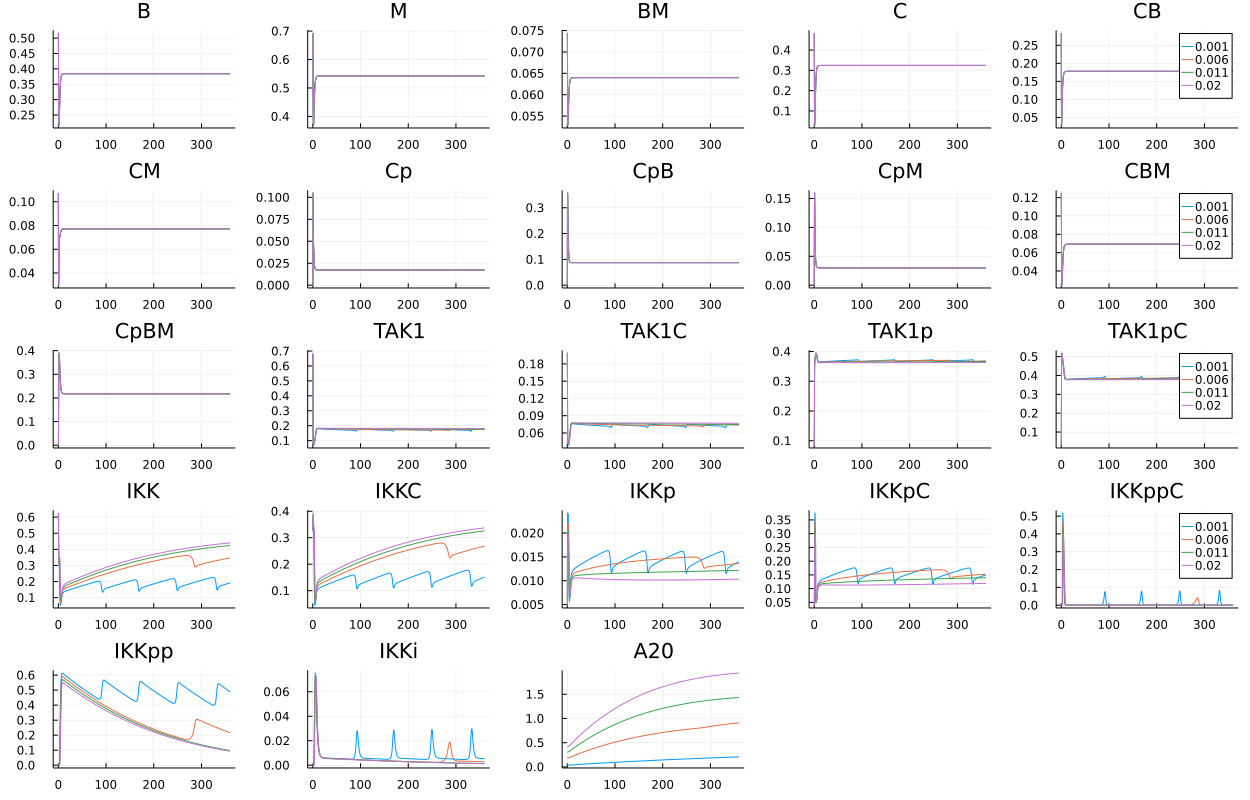

In [27]:
plotsols(sollist,syms,[0.001,0.006,0.011,0.02])
plot!(figsize=[1250,800],legend=[:none :none :none :none :topright])